In [20]:
%pylab inline

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# [ Loss 함수 정의 ]
 - 논문에서의 함수 :
 $$ L = \frac{1}{D} \sum_{i} \hat{\sigma_{i}}^{-2} ||y_i - \hat{y_{i}}||^{2} + \frac{1}{2}\log{\hat{\sigma_{i}}^{-2}}$$
 여기서, $\log{\hat{\sigma_{i}}^{-2}} = S_i$ 를 사용하여 아래와 같이 변형한다. ( more numerically stable)
 $$ L = \frac{1}{D} \sum_{i} \frac{1}{ exp(S_i) } ||y_i - \hat{y_{i}}||^{2} + \frac{1}{2} S_{i}$$
 - 아래의 코드에서...


    (1) 'si' : 논문의 함수 속 $S_i$


    (2) 'mu' : $ \hat{y_{i}} $

In [10]:
def gaussian_nll(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    mu = y_pred[:, 0]
    si = y_pred[:, 1]
    loss = (  si + tf.square(y_true - mu)/tf.math.exp(si)  ) / 2.0
    return tf.reduce_mean(loss)

# [ Model 정의 ]
##### * 2가지 포인트 有
 - 마지막 output이 ( $ \hat{\mu}, \sigma^{2} $ ) 형태가 되도록 한 구조
 - 위에서 논문에 맞게 정의한 loss함수를 사용하여 컴파일

In [11]:
def define():
    model = Sequential([
        Dense(16, activation='relu'),
        Dropout(.2),
        Dense(32, activation='relu'),
        Dropout(.2),
        Dense(32, activation='relu'),
        Dropout(.2),
        Dense(64, activation='relu'),
        Dropout(.2),
        Dense(2, activation=None)
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(optimizer=optim, loss=gaussian_nll)  # 오타 수정
    return model


def train(x, y, model, epochs=100):
    model.fit(x, y, 
              batch_size=32,
              epochs=epochs,
              verbose=0)
    return model

# [ MC dropout ]
 - 'training=True'로 설정해서 MC dropout 적용
 - 'y_mean' : 모델에서 출력되는 T개 y의 평균
 - 'si' : 모델에서 출력되는 scalar $ \log{ (\hat{\sigma}^2) } $

In [12]:
def predict(model, x, samples=20):
    '''
    Returns:
        y_mean: 예측의 기댓값
        y_std: 예측의 분산
    '''
    mu_arr = []
    si_arr = []
    for t in range(samples):
        # Dropout이 활성화된다. ( trainig=True )
        y_pred = model(x, training=True)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [13]:
# 결과시각화 위한 함수 정의
def plot_regression_model_analysis(gt=None,  trn=None, tst=None,
                                   pred=None, xlim=None, ylim=None,
                                   title=None):
    if gt:
        x_gt, y_gt = gt
        plt.plot(x_gt, y_gt, c='#F0AA00', 
                 alpha=.8, lw=2, label="ground truth")
    if trn:
        x_trn, y_trn = trn
        plt.scatter(x_trn,  y_trn,
                    s=8, ec='black', lw=1, fc=None, alpha=1,
                    label='train samples')
    
    if tst:
        x_tst, y_tst = tst
        plt.scatter(x_tst, y_tst, s=5, c='blue', alpha=.1, label='test samples')

    if pred:
        x_tst, yhat_mean, yhat_std = pred
        plt.scatter(x_tst, yhat_mean, s=5, c='magenta', alpha=1, label='preds')
        if yhat_std is not None:
            plt.fill_between(x_tst, (yhat_mean - 1.*yhat_std), (yhat_mean + 1.*yhat_std), lw=1,
                             ec='blue', fc='blue', alpha=.3, label='preds 1*std')
            plt.fill_between(x_tst, (yhat_mean - 2.*yhat_std), (yhat_mean + 2.*yhat_std), lw=1,
                             ec='blue', fc='blue', alpha=.2, label='preds 2*std')

    if xlim:
        plt.xlim(*xlim)
        
    if ylim:
        plt.ylim(*ylim)
    
    if title:
        plt.title(title)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(bbox_to_anchor=(1.35, 1.03), loc='upper right', fancybox=False, framealpha=1.0)

# [ Regression task 적용 실험 위한 toy dataset ]
 - sin함수 형태에 노이즈를 섞은 단순한 형태

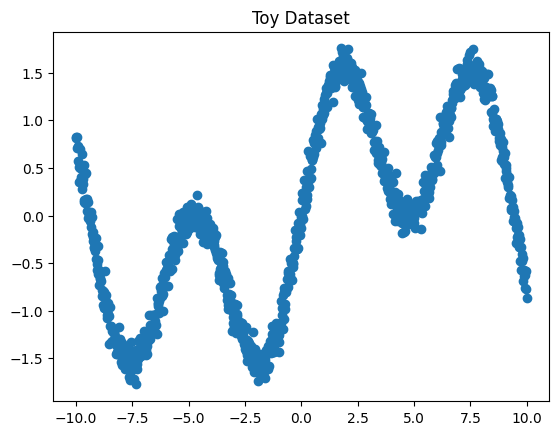

In [24]:
def make_toy_data(min, max, n_samples):
    A = np.linspace(min, max, n_samples)
    B = np.sin(A) + np.sin(A/3) + np.random.normal(0, 0.1, n_samples).astype(np.float32)
    all = np.stack((A, B), axis=1)
    return all


trn = make_toy_data(-3, 3, 1000)
tst = make_toy_data(-10, 10,1000)
gt = make_toy_data(-10, 10, 1000)

x_gt = gt[:,0]
y_gt = gt[:,1]
x_trn = trn[:,0]
y_trn = trn[:,1]
x_tst = tst[:,0]
y_tst = tst[:,1]

plt.title('Toy Dataset')
plt.scatter(gt[:, 0], gt[:, 1])
plt.show()

In [25]:
model = define()
model = train(x_trn[:, np.newaxis],
              y_trn[:, np.newaxis],
              model)

In [26]:
yhat_mean, yhat_std = predict(model, x_tst[:, np.newaxis], samples=5)

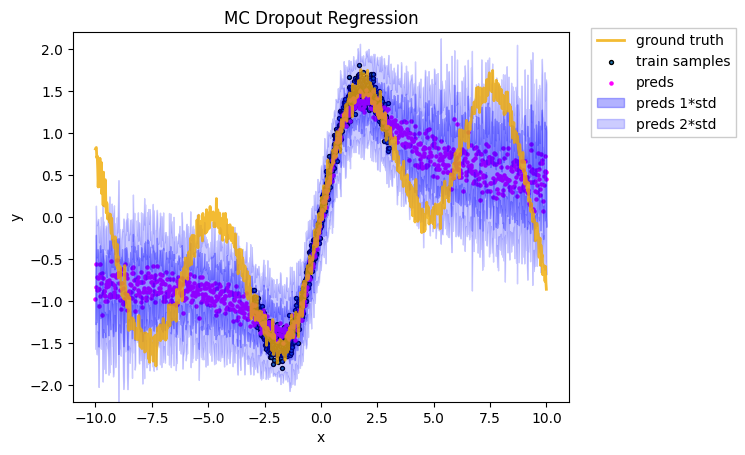

In [30]:
plot_regression_model_analysis(gt=(x_gt, y_gt),
                               trn=(x_trn, y_trn),
                               pred=(x_tst, yhat_mean, yhat_std),
                               xlim=(-11, 11),
                               ylim=(-2.2, 2.2),
                               title='MC Dropout Regression')